# Cyclical Learning using Fashion_MNIST dataset
## References:
1. Leslie Smith, "Cyclical Learning Rates for Training Neural Networks", arXiv: 1506.01186
2. https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.use("Agg")

import os, sys
import cv2, keras
from keras.models import Model
from keras.models import Sequential
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
#from keras.datasets import fashion_mnist
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, BatchNormalization, Input
#from keras.datasets import cifar10

from learningratefinder import LearningRateFinder
from clr_callback import CyclicLR
#from model.minigooglenet import MiniGoogLeNet

Using TensorFlow backend.


# Define hyper-parameters

In [2]:
# initialize the list of class label names
# CLASSES = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]

# define hyper-parameters
MIN_LR = 1e-5
MAX_LR = 1e-2
BATCH_SIZE = 50
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 48
lr_find = 1

# define plot path
LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot2.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot2.png"])
CLR_PLOT_PATH = os.path.sep.join(["output", "clr_plot2.png"])

# Load data

In [3]:
conv1,conv2,linear = (2, 2, 5, 1, 'same'), (2, 2, 5, 1, 'same'), ("", 512, 2)
channelsize = (49, 98)

classify_phase = [5, 1]
filename = ["20200310","G_eigenvector","7"]
kind_of_data = ["eigenvector_r_square_combine_theta_particle_hole","phase"]
line = "delta=0.5"
path = 'D:/program/vscode_workspace/private/data/project_data(phy)/train/'


CLASSES = []
for p in classify_phase:
    CLASSES.append(str(p))

def move(ph):
    if(line=="delta=0.5" or line=="delta=-0.5"):
        if(ph==5 or ph==6):
            m = 0
        elif(ph==1 or ph==2):
            m = 1000
        elif(ph==3 or ph==4):
            m = 2000
        elif(ph==7 or ph==8):
            m = 3000
        else:
            print("error")
    else:
        if(ph==5 or ph==1 or ph==3 or ph==7):
            m = 0
        elif(ph==6 or ph==2 or ph==4 or ph==8):
            m = 1000
        else:
            print("error")            
    return m

def get_train_data(phase):

    file = np.load((path+'{},{}_train,N={},{}.npz').format(filename[0],filename[1],filename[2],line))
    test_input = []
    test_target = []
    train_input = []
    train_target = []

    for i in range(len(phase)):
        test_input += file[kind_of_data[0]][800 + move(phase[i]) : 1000 + move(phase[i])].tolist()
        test_target += file[kind_of_data[1]][800 + move(phase[i]) : 1000 + move(phase[i])].tolist()
        train_input += file[kind_of_data[0]][0 + move(phase[i]) : 800 + move(phase[i])].tolist()
        train_target += file[kind_of_data[1]][0 + move(phase[i]) : 800 + move(phase[i])].tolist()

    test_input = np.array(test_input)[:,1:3,:,:]
    test_target = np.array(test_target)
    train_input = np.array(train_input)[:,1:3,:,:]
    train_target = np.array(train_target)

    return [test_input, test_target, train_input, train_target]

total_data = get_train_data(classify_phase)    

print("[INFO] loading Fashion data...")
X_train, Y_train, X_test, Y_test = total_data[2], total_data[3], total_data[0], total_data[1]

# Fashion MNIST images are 28x28, reshape to 32x32
# X_train = np.array([cv2.resize(x, (channelsize[0], channelsize[1])) for x in X_train])
# X_test = np.array([cv2.resize(x, (channelsize[0], channelsize[1])) for x in X_test])

# normalization
X_train = X_train.astype("float") / 255.0
X_test = X_test.astype("float") / 255.0

# reshape
# print("X_train : ",np.shape(X_train))
# print("X_test : ",np.shape(X_test))
X_train = X_train.transpose((0,2,3,1)) #.reshape((X_train.shape[0], channelsize[0], channelsize[1], conv1[0]))
X_test = X_test.transpose((0,2,3,1))   #reshape((X_test.shape[0], channelsize[0], channelsize[1], conv1[0]))

"""One can also try cifar10 dataset
print("[INFO] loading CIFAR-10 data...")
((X_train, Y_train), (X_test, Y_test)) = cifar10.load_data()
X_train = X_train.astype("float")
X_test = X_test.astype("float")

# apply mean subtraction to the data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean
"""
# One-hot encoding
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

if(len(classify_phase)==2):
    Y_train = Y_train.tolist()
    Y_test = Y_test.tolist()
    for i in range(len(Y_train)): Y_train[i].append(1-Y_train[i][0])
    for i in range(len(Y_test )): Y_test[i].append(1-Y_test[i][0])
    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)

[INFO] loading Fashion data...


In [4]:
# construct the image generator for data augmentation
gen_aug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, fill_mode="nearest")

# Model construction

In [5]:
def resnet(input_shape):
    inputs = Input(shape=input_shape)

    x = Convolution2D(batch_input_shape=(None, channelsize[0], channelsize[1], conv1[0]), 
                      filters=conv1[1], 
                      kernel_size=conv1[2], 
                      strides=conv1[3],
                      padding=conv1[4])(inputs)
    x = BatchNormalization()(x)    
    x = Activation('relu')(x)
    x = Convolution2D(filters=conv2[1], 
                      kernel_size=conv2[2], 
                      strides=conv2[3],
                      padding=conv2[4])(x)
    x = BatchNormalization()(x)    
    x = Activation('relu')(x)
    
    x = keras.layers.add([x,inputs])
    
    x = Flatten()(x)
    x = Dense(linear[1])(x)
    x = Dense(linear[2])(x)
    outputs = Activation('softmax')(x)
    
    return Model(inputs=inputs,outputs=outputs)

model = resnet((channelsize[0], channelsize[1], conv1[0]))


In [6]:
# initialize a model
#model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 49, 98, 2)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 49, 98, 2)    102         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 49, 98, 2)    8           conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 49, 98, 2)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [7]:
# initialize the optimizer
print("[INFO] compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


# Find learning rate

[INFO] finding learning rate...


C:\Users\Cheng\Anaconda3\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1600, 49, 98, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/64
32/32 [==============================] - 3s 90ms/step - loss: 1.0887 - accuracy: 0.4981
Epoch 2/64
32/32 [==============================] - 2s 50ms/step - loss: 1.1064 - accuracy: 0.4981
Epoch 3/64
32/32 [==============================] - 2s 50ms/step - loss: 1.0976 - accuracy: 0.4950
Epoch 4/64
32/32 [==============================] - 2s 50ms/step - loss: 1.1408 - accuracy: 0.5025
Epoch 5/64
32/32 [==============================] - 2s 64ms/step - loss: 1.0973 - accuracy: 0.4994
Epoch 6/64
32/32 [==============================] - 2s 59ms/step - loss: 1.1173 - accuracy: 0.4994
Epoch 7/64
32/32 [==============================] - 2s 60ms/step - loss: 1.0857 - accuracy: 0.5019
Epoch 8/64
32/32 [==============================] - 2s 57ms/step - loss: 1.1031 - accuracy: 0.4981
Epoch 9/64
32/32 [==============================] - 2s 57ms/step - loss: 1.1118 - accuracy: 0.5013
Epoch 10/64
32/32 [==============================] - 2s 56ms/step - loss: 1.1031 - accuracy: 0.5069
Epoch 11/

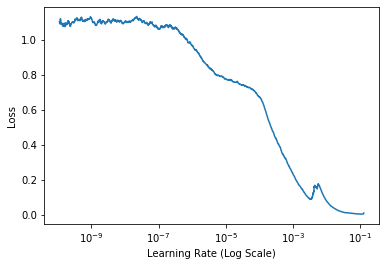

In [8]:
if lr_find > 0:
# initialize the learning rate finder (from 1e-10 to 1e+1)
    print("[INFO] finding learning rate...")
    lrf = LearningRateFinder(model)
    lrf.find(gen_aug.flow(X_train, Y_train, batch_size=BATCH_SIZE), 1e-10, 1e+1,
    stepsPerEpoch=np.ceil((len(X_train) / float(BATCH_SIZE))), batchSize=BATCH_SIZE)

    # plot the loss and save the resulting plot to disk
    lrf.plot_loss()
    plt.savefig(LRFIND_PLOT_PATH)
    
    print("[INFO] learning rate finder complete")
    print("[INFO] examine plot and adjust learning rates before training")
    #exit(0)

# Cyclical training

In [9]:
# otherwise, we have already defined a learning rate space to train
# over, so compute the step size and initialize the cyclic learning
# rate method
stepSize = STEP_SIZE * (X_train.shape[0] // BATCH_SIZE)
clr = CyclicLR(mode=CLR_METHOD, base_lr=MIN_LR, max_lr=MAX_LR, step_size=stepSize)

# train the network
print("[INFO] training network...")
H = model.fit_generator(gen_aug.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, Y_test),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[clr],
    verbose=1)

# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(X_test, batch_size=BATCH_SIZE)
print(classification_report(Y_test.argmax(axis=1),
predictions.argmax(axis=1), target_names=CLASSES))

[INFO] training network...
Epoch 1/48

C:\Users\Cheng\Anaconda3\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1600, 49, 98, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')



32/32 [==============================] - 2s 64ms/step - loss: 12.6984 - accuracy: 0.4837 - val_loss: 2955.7201 - val_accuracy: 0.5000
Epoch 2/48
32/32 [==============================] - 2s 56ms/step - loss: 0.7307 - accuracy: 0.6137 - val_loss: 1918.7029 - val_accuracy: 0.5000
Epoch 3/48
32/32 [==============================] - 2s 58ms/step - loss: 0.5182 - accuracy: 0.7462 - val_loss: 407.2626 - val_accuracy: 0.5000
Epoch 4/48
32/32 [==============================] - 2s 58ms/step - loss: 0.4374 - accuracy: 0.7881 - val_loss: 16.8049 - val_accuracy: 0.5000
Epoch 5/48
32/32 [==============================] - 2s 59ms/step - loss: 0.3367 - accuracy: 0.8587 - val_loss: 3.0179 - val_accuracy: 0.5000
Epoch 6/48
32/32 [==============================] - 2s 58ms/step - loss: 0.2370 - accuracy: 0.9125 - val_loss: 1.7284 - val_accuracy: 0.5000
Epoch 7/48
32/32 [==============================] - 2s 58ms/step - loss: 0.3123 - accuracy: 0.9000 - val_loss: 1.7380 - val_accuracy: 0.5000
Epoch 8/48
32

# Plot results

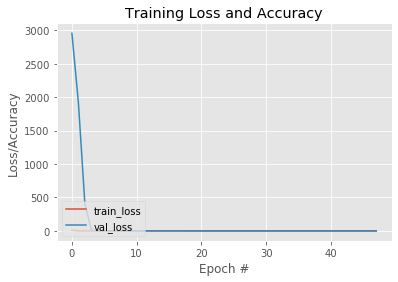

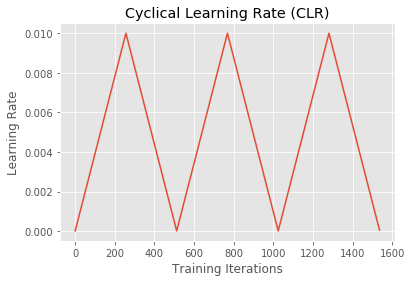

In [10]:
# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
# plt.plot(N, H.history["acc"], label="train_acc")
# plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_PATH)

# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.savefig(CLR_PLOT_PATH)